# Project Name

***Title: Improving Model Generalization and Robustness to Adversarial Attacks in Skin Lesion Classification***<br>
Phase 1: Data Preprocessing <br>
Phase 2: Data Augmentation<br>
Phase 3: DenseNet201 Model<br>

<h4>Submitted by: </h4>
Name: Md Mahfuzur Rohman <br>
Roll: 1918016<br>
Reg. No: 1324<br>
Year: 4th Year<br>
Session: 2019-2020<br>

<h4>Supervised by:</h4>
Dr. Md. Sipon Miah<br>
Professor<br>
Department of Information and Communication Technology<br>
Islamic University, Kushtia-7003<br>


### Import Libraries


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from PIL import Image

import keras
from tensorflow.keras.utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import to_categorical # convert to one-hot-encoding

from keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split

### Mount Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import the DataSet from Google Drive

In [3]:
import os
import pandas as pd

train_dir = '/content/drive/MyDrive/Project Thesis/Skin Cancer ISIC Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/'
test_dir = '/content/drive/MyDrive/Project Thesis/Skin Cancer ISIC Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Test/'

# Create empty lists to store image paths and labels
train_data = []
test_data = []

# Add image paths and labels to the lists for the training set
for label, directory in enumerate(os.listdir(train_dir)):
    for filename in os.listdir(os.path.join(train_dir, directory)):
        image_path = os.path.join(train_dir, directory, filename)
        train_data.append({'image_path': image_path, 'label': label})

# Add image paths and labels to the lists for the test set
for label, directory in enumerate(os.listdir(test_dir)):
    for filename in os.listdir(os.path.join(test_dir, directory)):
        image_path = os.path.join(test_dir, directory, filename)
        test_data.append({'image_path': image_path, 'label': label})

# Convert the lists into DataFrames
train_df = pd.DataFrame(train_data)
test_df = pd.DataFrame(test_data)

# Combine train_df and test_df into one DataFrame
df = pd.concat([train_df, test_df], ignore_index=True)

# Clean up
del train_df, test_df

df  # Display the final dataframe

,image_path,label
0,/content/drive/MyDrive/Project Thesis/Skin Can...,0
1,/content/drive/MyDrive/Project Thesis/Skin Can...,0
2,/content/drive/MyDrive/Project Thesis/Skin Can...,0
3,/content/drive/MyDrive/Project Thesis/Skin Can...,0
4,/content/drive/MyDrive/Project Thesis/Skin Can...,0
...,...,...
2352,/content/drive/MyDrive/Project Thesis/Skin Can...,8
2353,/content/drive/MyDrive/Project Thesis/Skin Can...,8
2354,/content/drive/MyDrive/Project Thesis/Skin Can...,8
2355,/content/drive/MyDrive/Project Thesis/Skin Can...,8


In [4]:
# Get list of directories in train_dir
labels = os.listdir(train_dir)

# Create label_map dictionary
label_map = {i: label for i, label in enumerate(labels)}
num_classes=len(label_map)
label_map

{0: 'actinic keratosis',
 1: 'nevus',
 2: 'vascular lesion',
 3: 'seborrheic keratosis',
 4: 'pigmented benign keratosis',
 5: 'dermatofibroma',
 6: 'squamous cell carcinoma',
 7: 'basal cell carcinoma',
 8: 'melanoma'}

 ### Exploratory Data Analysis about the Dataset

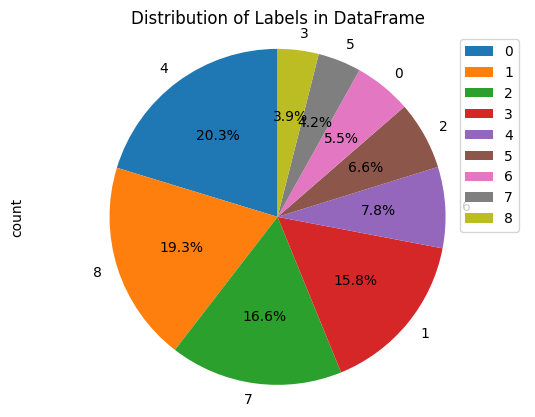

In [5]:
# Plot pie chart of train_df
df['label'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Distribution of Labels in DataFrame')
plt.legend(df['label'].unique())
plt.show()

In [6]:
# Count the number of images in each class
class_counts = df['label'].value_counts().sort_index()

# Print the number of images in each class
print("Dataset Summary")
print("-" * 60)
print(f"{'Class Label':<15} {'Class Name':<30} {'Count':<10}")
print("-" * 60)
for class_label, class_name in label_map.items():
    count = class_counts[class_label]
    print(f"{class_label:<15} {class_name:<30} {count:<10}")
print("-" * 60)
print(f"{'Total':<45} {sum(class_counts):<10}")

Dataset Summary
------------------------------------------------------------
Class Label     Class Name                     Count     
------------------------------------------------------------
0               actinic keratosis              130       
1               nevus                          373       
2               vascular lesion                155       
3               seborrheic keratosis           93        
4               pigmented benign keratosis     478       
5               dermatofibroma                 98        
6               squamous cell carcinoma        184       
7               basal cell carcinoma           392       
8               melanoma                       454       
------------------------------------------------------------
Total                                         2357      


## Phase 1: Data Preprocessing

In [7]:
max_images_per_class = 2500

# Group by label column and take first max_images_per_class rows for each group
df = df.groupby("label").apply(lambda x: x.head(max_images_per_class)).reset_index(drop=True)

### Set GPT Configuration

In [8]:
import tensorflow as tf

# Allow gpu usage
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
try:
    tf.config.experimental.set_memory_growth = True
except Exception as ex:
    print(e)

[]


In [9]:
import multiprocessing

# Get the number of CPU cores available
max_workers = multiprocessing.cpu_count()
max_workers

96

In [10]:
import concurrent.futures

# Define a function to resize image arrays
def resize_image_array(image_path):
    return np.asarray(Image.open(image_path).resize((100,75)))

# Use concurrent.futures to parallelize the resizing process
with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
    # Use executor.map to apply the function to each image path in the DataFrame
    image_arrays = list(executor.map(resize_image_array, df['image_path'].tolist()))

# Add the resized image arrays to the DataFrame
df['image'] = image_arrays
del image_arrays

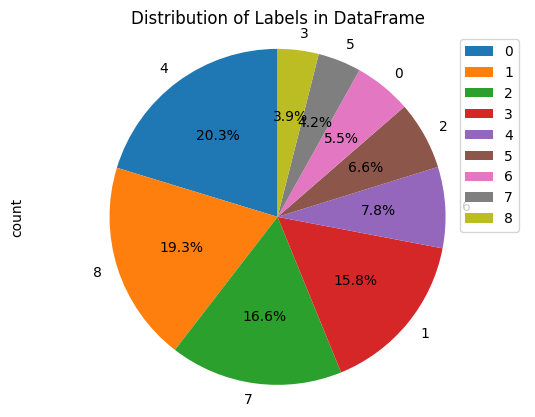

In [11]:
# Plot pie chart of train_df
df['label'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Distribution of Labels in DataFrame')
plt.legend(df['label'].unique())
plt.show()

In [12]:
df.head()

,image_path,label,image
0,/content/drive/MyDrive/Project Thesis/Skin Can...,0,"[[[149, 93, 103], [148, 87, 99], [148, 90, 101..."
1,/content/drive/MyDrive/Project Thesis/Skin Can...,0,"[[[180, 134, 141], [182, 138, 142], [184, 140,..."
2,/content/drive/MyDrive/Project Thesis/Skin Can...,0,"[[[156, 120, 133], [151, 107, 120], [146, 101,..."
3,/content/drive/MyDrive/Project Thesis/Skin Can...,0,"[[[140, 81, 91], [141, 82, 90], [146, 85, 94],..."
4,/content/drive/MyDrive/Project Thesis/Skin Can...,0,"[[[174, 135, 170], [175, 134, 169], [175, 132,..."


### Total number of Images before Data augmentation

In [13]:
# Count the number of images in each class
class_counts = df['label'].value_counts().sort_index()

# Print the number of images in each class
print("Dataset Summary")
print("-" * 60)
print(f"{'Class Label':<15} {'Class Name':<30} {'Count':<10}")
print("-" * 60)
for class_label, class_name in label_map.items():
    count = class_counts[class_label]
    print(f"{class_label:<15} {class_name:<30} {count:<10}")
print("-" * 60)
print(f"{'Total':<45} {sum(class_counts):<10}")

Dataset Summary
------------------------------------------------------------
Class Label     Class Name                     Count     
------------------------------------------------------------
0               actinic keratosis              130       
1               nevus                          373       
2               vascular lesion                155       
3               seborrheic keratosis           93        
4               pigmented benign keratosis     478       
5               dermatofibroma                 98        
6               squamous cell carcinoma        184       
7               basal cell carcinoma           392       
8               melanoma                       454       
------------------------------------------------------------
Total                                         2357      


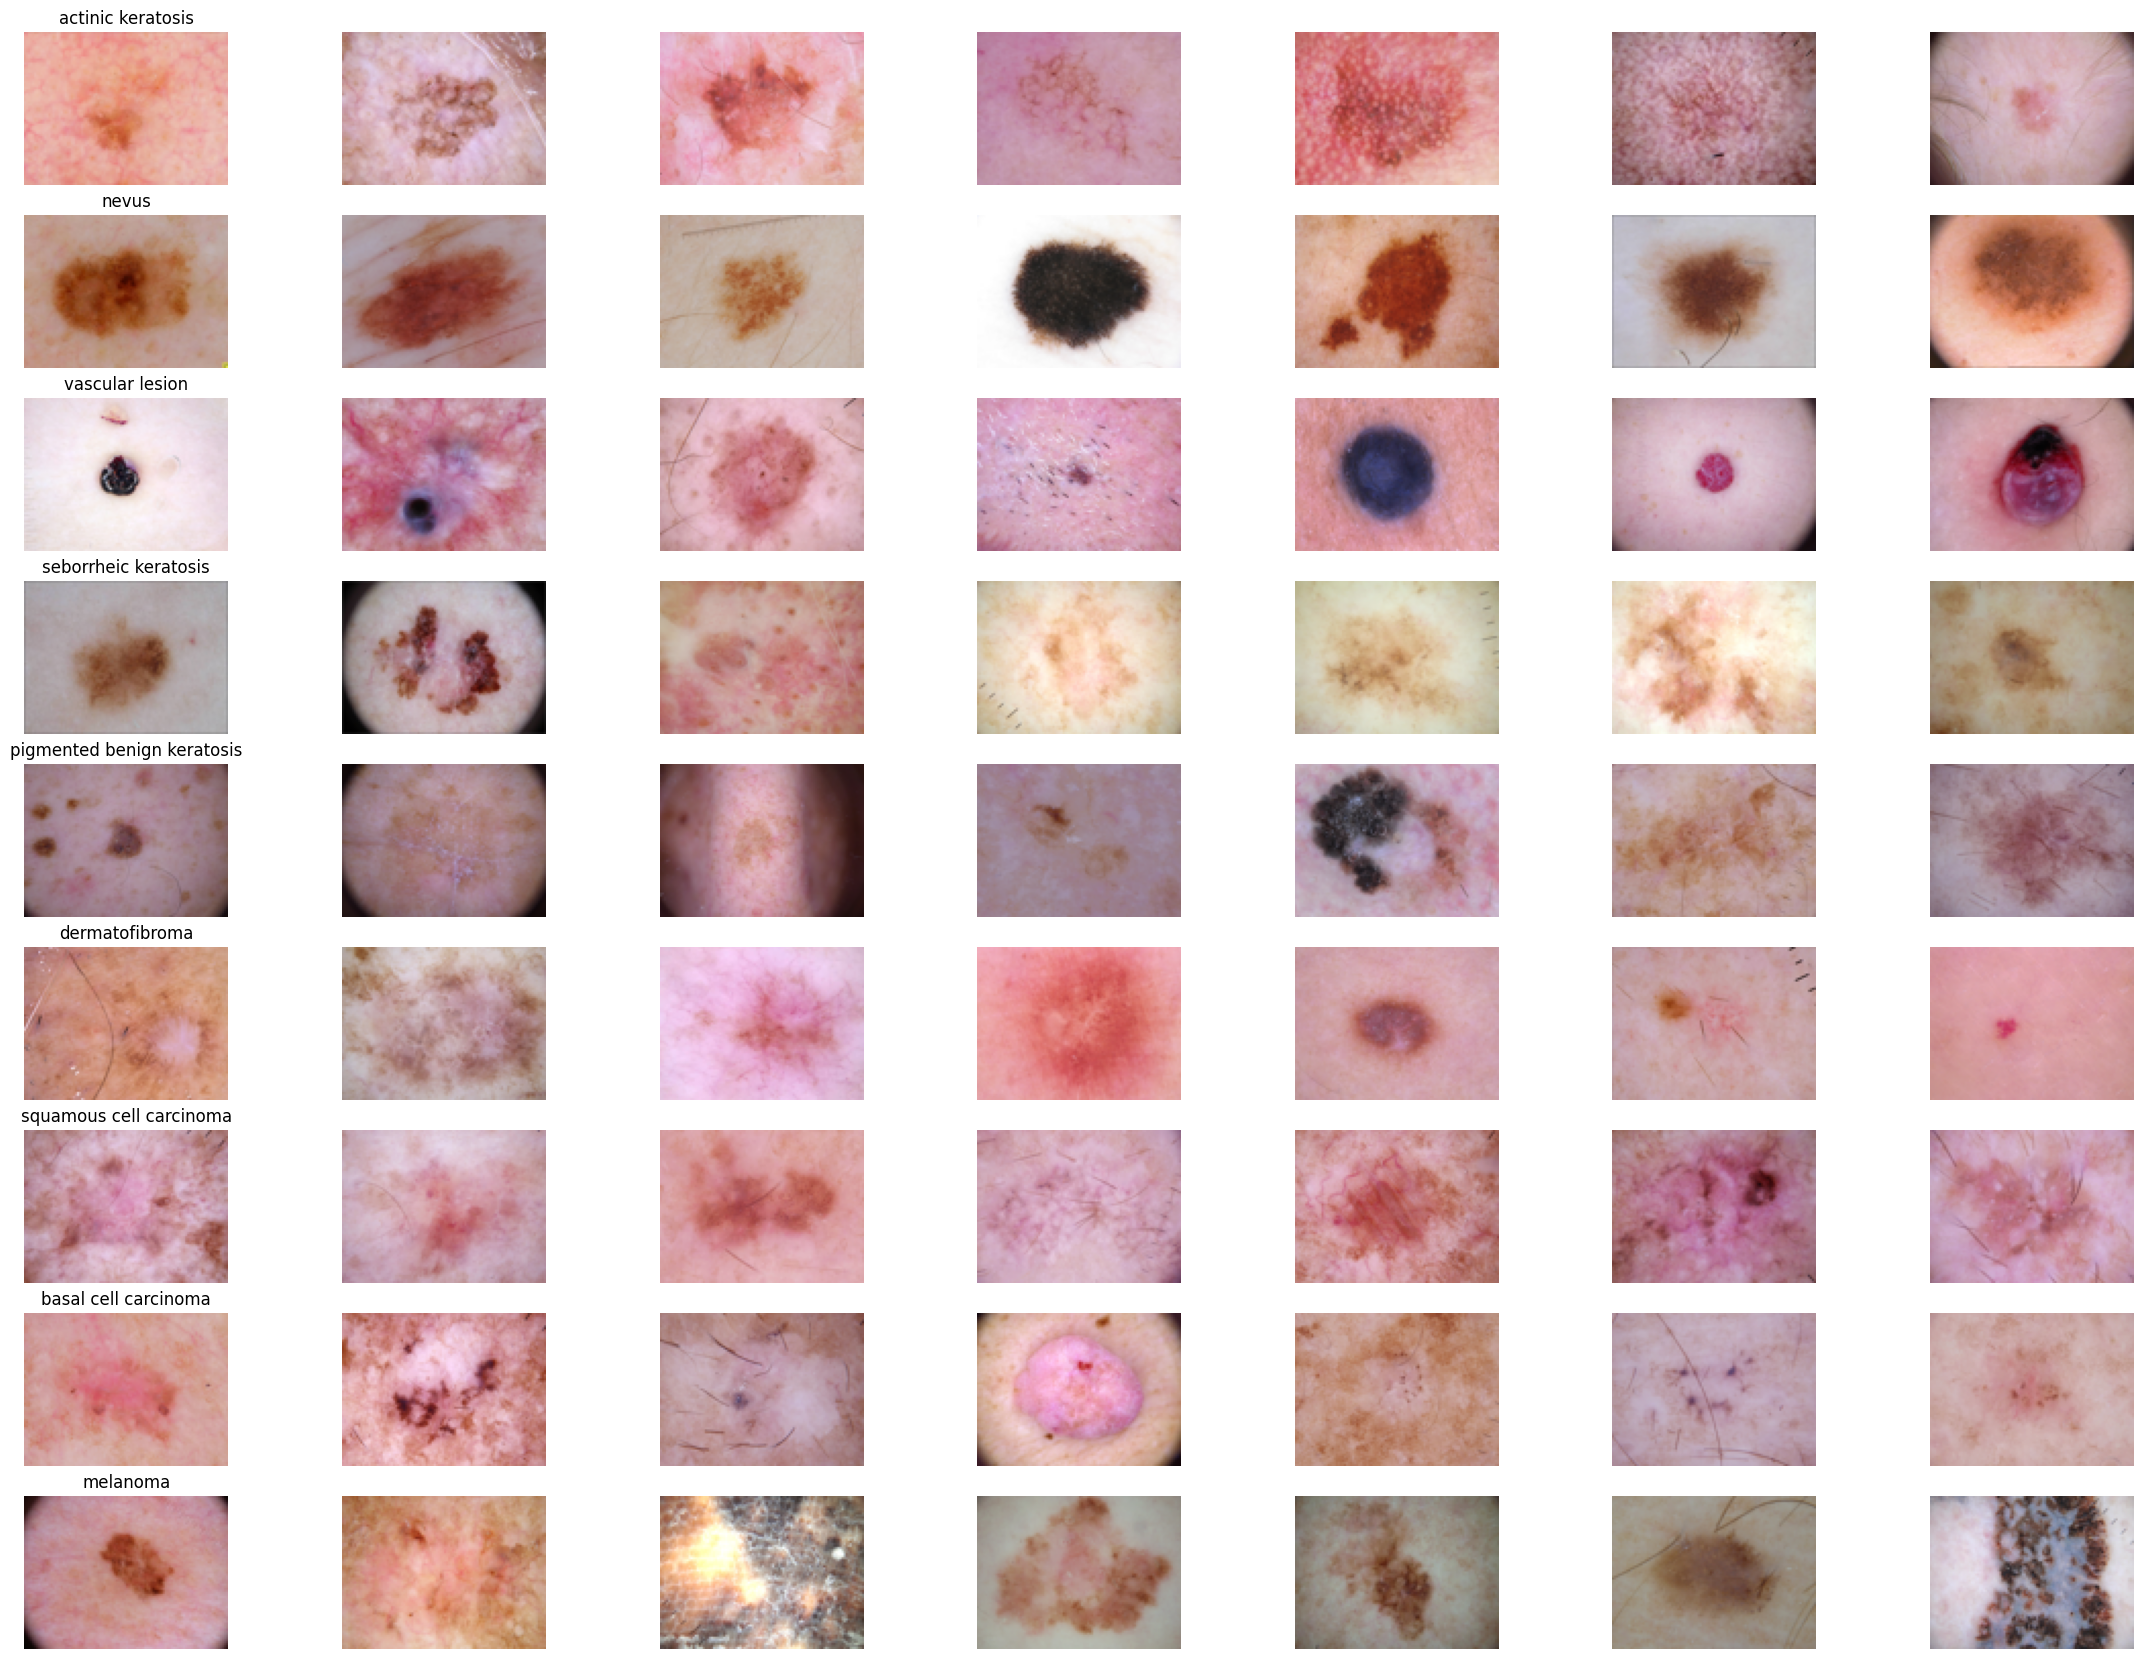

In [14]:
n_samples = 7
fig, m_axs = plt.subplots(num_classes, n_samples, figsize=(4*n_samples, 3*7))
for n_axs, (class_idx, class_rows) in zip(m_axs, df.sort_values(['label']).groupby('label')):
    class_name = label_map[class_idx] # get the class name using label_map
    n_axs[0].set_title(class_name)
    for c_ax, (_, c_row) in zip(n_axs, class_rows.sample(n_samples, random_state=5).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

In [15]:
df['image'].map(lambda x: x.shape).value_counts()

,count
image,
"(75, 100, 3)",2357


## Phase 2: Data augmentation

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an ImageDataGenerator object with the desired transformations
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [17]:
# Create an empty dataframe to store the augmented images
augmented_df = pd.DataFrame(columns=['image_path', 'label', 'image'])

# Loop through each class label and generate additional images if needed
for class_label in df['label'].unique():
    # Get the image arrays for the current class
    image_arrays = df.loc[df['label'] == class_label, 'image'].values

    # Calculate the number of additional images needed for the current class
    num_images_needed = max_images_per_class - len(image_arrays)

    # Generate augmented images for the current class
    if num_images_needed > 0:
        # Select a random subset of the original images
        selected_images = np.random.choice(image_arrays, size=num_images_needed)

        # Apply transformations to the selected images and add them to the augmented dataframe
        for image_array in selected_images:
            # Reshape the image array to a 4D tensor with a batch size of 1
            image_tensor = np.expand_dims(image_array, axis=0)

            # Generate the augmented images
            augmented_images = datagen.flow(image_tensor, batch_size=1)

            # Extract the augmented image arrays and add them to the augmented dataframe
            for i in range(augmented_images.n):
                augmented_image_array = next(augmented_images)[0].astype('uint8')
                augmented_df = pd.concat([augmented_df, pd.DataFrame({'image_path': [None], 'label': [class_label], 'image': [augmented_image_array]})], ignore_index=True)

    # Add the original images for the current class to the augmented dataframe
    original_images_df = df.loc[df['label'] == class_label, ['image_path', 'label', 'image']]
    augmented_df = pd.concat([augmented_df, original_images_df], ignore_index=True)

# Group the augmented dataframe by the 'label' column and filter out extra images
df = augmented_df.groupby('label').head(max_images_per_class)

del augmented_df

# Use the augmented dataframe for further processing
df = df.sample(frac=1, random_state=42).reset_index(drop=True)


### Total number of images of each Class after Data Augmentation

In [18]:
# Count the number of images in each class
class_counts = df['label'].value_counts().sort_index()

# Print the number of images in each class
print("Dataset Summary")
print("-" * 60)
print(f"{'Class Label':<15} {'Class Name':<30} {'Count':<10}")
print("-" * 60)
for class_label, class_name in label_map.items():
    count = class_counts[class_label]
    print(f"{class_label:<15} {class_name:<30} {count:<10}")
print("-" * 60)
print(f"{'Total':<45} {sum(class_counts):<10}")

Dataset Summary
------------------------------------------------------------
Class Label     Class Name                     Count     
------------------------------------------------------------
0               actinic keratosis              2500      
1               nevus                          2500      
2               vascular lesion                2500      
3               seborrheic keratosis           2500      
4               pigmented benign keratosis     2500      
5               dermatofibroma                 2500      
6               squamous cell carcinoma        2500      
7               basal cell carcinoma           2500      
8               melanoma                       2500      
------------------------------------------------------------
Total                                         22500     


### Split the Train and Test Dataset

In [19]:
features = df.drop(columns=['label','image_path'],axis=1)
target = df['label']

In [20]:
target.head()

,label
0,0
1,3
2,7
3,3
4,4


In [21]:
print(target.shape,features.shape)

(22500,) (22500, 1)


In [23]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.20,shuffle=True)

### Normalization of Data

In [24]:
x_train = np.asarray(x_train['image'].tolist())
x_test = np.asarray(x_test['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)
x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

### Label Encoding

In [25]:
# Perform one-hot encoding on the labels
y_train = to_categorical(y_train,num_classes = num_classes)
y_test = to_categorical(y_test,num_classes = num_classes)

### Splitting the data into training and Validation Split

In [26]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.2,shuffle=True)

In [27]:
# Reshape image in 3 dimensions (height = 75px, width = 100px , canal = 3)
x_train = x_train.reshape(x_train.shape[0], *(75, 100, 3))
x_test = x_test.reshape(x_test.shape[0], *(75, 100, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(75, 100, 3))

In [28]:
y_train = y_train.astype(int)
y_validate = y_validate.astype(int)

### Displaying the total number of images of each Class

In [29]:
# Calculate the number of images in each class for train, validation, and test datasets
train_counts = np.sum(y_train, axis=0)
val_counts = np.sum(y_validate, axis=0)
test_counts = np.sum(y_test, axis=0)

# Print the number of images in each class for train, validation, and test datasets
print("Dataset Summary")
print("-" * 90)
print(f"{'Class Label':<15} {'Class Name':<30} {'Train':<10} {'Validation':<12} {'Test':<10} {'Total':<10}")
print("-" * 90)
for class_label, class_name in label_map.items():
    train_num = int(train_counts[class_label])
    val_num = int(val_counts[class_label])
    test_num = int(test_counts[class_label])
    total_num = train_num + val_num + test_num
    print(f"{class_label:<15} {class_name:<30} {train_num:<10} {val_num:<12} {test_num:<10} {total_num:<10}")
print("-" * 90)
print(f"{'Total':<46} {len(y_train):<10} {len(y_validate):<12} {len(y_test):<10} {len(y_train) + len(y_validate) + len(y_test):<10}")

Dataset Summary
------------------------------------------------------------------------------------------
Class Label     Class Name                     Train      Validation   Test       Total     
------------------------------------------------------------------------------------------
0               actinic keratosis              1580       413          507        2500      
1               nevus                          1616       396          488        2500      
2               vascular lesion                1627       382          491        2500      
3               seborrheic keratosis           1595       410          495        2500      
4               pigmented benign keratosis     1544       416          540        2500      
5               dermatofibroma                 1609       390          501        2500      
6               squamous cell carcinoma        1625       383          492        2500      
7               basal cell carcinoma           1604       

In [30]:
df.groupby('label').size()

,0
label,
0,2500
1,2500
2,2500
3,2500
4,2500
5,2500
6,2500
7,2500
8,2500


In [31]:
input_shape = df['image'][0].shape

## Phase 3: DesneNet201 Model Apply

In [32]:
from tensorflow.keras.applications.resnet import preprocess_input as resnet_preprocess_input
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout

# DenseNet201
model = Sequential()
model.add(DenseNet201(include_top=False, weights='imagenet', input_shape=input_shape))
model.add(Flatten())
model.add(Dropout(0.5))  # Add a Dropout layer with a dropout rate of 0.5
model.add(Dense(512, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

74836368/74836368 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 2, 3, 1920)        18321984  
                                                                 
 flatten (Flatten)           (None, 11520)             0         
                                                                 
 dropout (Dropout)           (None, 11520)             0         
                                                                 
 dense (Dense)               (None, 512)               5898752   
                                                                 
 dense_1 (Dense)             (None, 9)                 4617      
                                                                 
Total params: 24225353 (92.41 MB)
Trainable params: 23996297 (91.54 MB)
Non-trainable params: 229056 (894.75 KB)
__________

### Apply SGD Optimizer

In [33]:
# compile model
from keras.optimizers import SGD
opt = SGD(learning_rate=0.001, momentum=0.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])


# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

### Train the Model with 25 epochs

In [34]:
# Fit the model
epochs = 25
batch_size=32
history = model.fit(x=x_train,
                    y=y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(x_validate,y_validate),
                    callbacks=learning_rate_reduction)

Epoch 1/25
450/450 [==============================] - ETA: 0s - loss: 1.2941 - accuracy: 0.5443

450/450 [==============================] - 429s 898ms/step - loss: 1.2941 - accuracy: 0.5443 - val_loss: 0.7790 - val_accuracy: 0.7047 - lr: 0.0010
Epoch 2/25
450/450 [==============================] - ETA: 0s - loss: 0.6349 - accuracy: 0.7633

450/450 [==============================] - 390s 867ms/step - loss: 0.6349 - accuracy: 0.7633 - val_loss: 0.5251 - val_accuracy: 0.7864 - lr: 0.0010
Epoch 3/25
450/450 [==============================] - ETA: 0s - loss: 0.3894 - accuracy: 0.8508

450/450 [==============================] - 390s 866ms/step - loss: 0.3894 - accuracy: 0.8508 - val_loss: 0.4248 - val_accuracy: 0.8433 - lr: 0.0010
Epoch 4/25
450/450 [==============================] - ETA: 0s - loss: 0.2841 - accuracy: 0.8962

450/450 [==============================] - 390s 868ms/step - loss: 0.2841 - accuracy: 0.8962 - val_loss: 0.3469 - val_accuracy: 0.8683 - lr: 0.0010
Epoch 5/25
450/450 [==============================] - ETA: 0s - loss: 0.2032 - accuracy: 0.9224

450/450 [==============================] - 390s 866ms/step - loss: 0.2032 - accuracy: 0.9224 - val_loss: 0.3892 - val_accuracy: 0.8658 - lr: 0.0010
Epoch 6/25
450/450 [==============================] - ETA: 0s - loss: 0.1882 - accuracy: 0.9300

450/450 [==============================] - 390s 868ms/step - loss: 0.1882 - accuracy: 0.9300 - val_loss: 0.3570 - val_accuracy: 0.8664 - lr: 0.0010
Epoch 7/25
450/450 [==============================] - ETA: 0s - loss: 0.1594 - accuracy: 0.9438

450/450 [==============================] - 391s 870ms/step - loss: 0.1594 - accuracy: 0.9438 - val_loss: 0.3242 - val_accuracy: 0.8958 - lr: 0.0010
Epoch 8/25
450/450 [==============================] - ETA: 0s - loss: 0.1162 - accuracy: 0.9565

450/450 [==============================] - 390s 867ms/step - loss: 0.1162 - accuracy: 0.9565 - val_loss: 0.3159 - val_accuracy: 0.8956 - lr: 0.0010
Epoch 9/25
450/450 [==============================] - ETA: 0s - loss: 0.1146 - accuracy: 0.9591

450/450 [==============================] - 390s 866ms/step - loss: 0.1146 - accuracy: 0.9591 - val_loss: 0.4326 - val_accuracy: 0.8583 - lr: 0.0010
Epoch 10/25
450/450 [==============================] - ETA: 0s - loss: 0.0928 - accuracy: 0.9653

450/450 [==============================] - 390s 866ms/step - loss: 0.0928 - accuracy: 0.9653 - val_loss: 0.4651 - val_accuracy: 0.8675 - lr: 0.0010
Epoch 11/25
450/450 [==============================] - ETA: 0s - loss: 0.0840 - accuracy: 0.9704

450/450 [==============================] - 389s 865ms/step - loss: 0.0840 - accuracy: 0.9704 - val_loss: 0.4508 - val_accuracy: 0.8708 - lr: 0.0010
Epoch 12/25
450/450 [==============================] - ETA: 0s - loss: 0.0651 - accuracy: 0.9763

450/450 [==============================] - 390s 867ms/step - loss: 0.0651 - accuracy: 0.9763 - val_loss: 0.3556 - val_accuracy: 0.9050 - lr: 0.0010
Epoch 13/25
450/450 [==============================] - ETA: 0s - loss: 0.0624 - accuracy: 0.9774

450/450 [==============================] - 390s 867ms/step - loss: 0.0624 - accuracy: 0.9774 - val_loss: 0.4125 - val_accuracy: 0.8903 - lr: 0.0010
Epoch 14/25
450/450 [==============================] - ETA: 0s - loss: 0.0659 - accuracy: 0.9770

450/450 [==============================] - 390s 866ms/step - loss: 0.0659 - accuracy: 0.9770 - val_loss: 0.3389 - val_accuracy: 0.9061 - lr: 0.0010
Epoch 15/25
450/450 [==============================] - ETA: 0s - loss: 0.0559 - accuracy: 0.9799

450/450 [==============================] - 390s 867ms/step - loss: 0.0559 - accuracy: 0.9799 - val_loss: 0.3805 - val_accuracy: 0.9000 - lr: 0.0010
Epoch 16/25
450/450 [==============================] - ETA: 0s - loss: 0.0532 - accuracy: 0.9823

450/450 [==============================] - 391s 869ms/step - loss: 0.0532 - accuracy: 0.9823 - val_loss: 0.3800 - val_accuracy: 0.9022 - lr: 0.0010
Epoch 17/25
450/450 [==============================] - ETA: 0s - loss: 0.0443 - accuracy: 0.9843

450/450 [==============================] - 389s 865ms/step - loss: 0.0443 - accuracy: 0.9843 - val_loss: 0.3844 - val_accuracy: 0.9006 - lr: 0.0010
Epoch 18/25
450/450 [==============================] - ETA: 0s - loss: 0.0377 - accuracy: 0.9849

450/450 [==============================] - 389s 865ms/step - loss: 0.0377 - accuracy: 0.9849 - val_loss: 0.3995 - val_accuracy: 0.8967 - lr: 0.0010
Epoch 19/25
450/450 [==============================] - ETA: 0s - loss: 0.0368 - accuracy: 0.9867

450/450 [==============================] - 389s 865ms/step - loss: 0.0368 - accuracy: 0.9867 - val_loss: 0.4187 - val_accuracy: 0.9081 - lr: 0.0010
Epoch 20/25
450/450 [==============================] - ETA: 0s - loss: 0.0340 - accuracy: 0.9860

450/450 [==============================] - 391s 869ms/step - loss: 0.0340 - accuracy: 0.9860 - val_loss: 0.4134 - val_accuracy: 0.9069 - lr: 0.0010
Epoch 21/25
450/450 [==============================] - ETA: 0s - loss: 0.0333 - accuracy: 0.9874

450/450 [==============================] - 390s 868ms/step - loss: 0.0333 - accuracy: 0.9874 - val_loss: 0.3915 - val_accuracy: 0.8942 - lr: 0.0010
Epoch 22/25
450/450 [==============================] - ETA: 0s - loss: 0.0299 - accuracy: 0.9883

450/450 [==============================] - 390s 868ms/step - loss: 0.0299 - accuracy: 0.9883 - val_loss: 0.3991 - val_accuracy: 0.9125 - lr: 0.0010
Epoch 23/25
450/450 [==============================] - ETA: 0s - loss: 0.0282 - accuracy: 0.9889

450/450 [==============================] - 389s 866ms/step - loss: 0.0282 - accuracy: 0.9889 - val_loss: 0.4774 - val_accuracy: 0.8939 - lr: 0.0010
Epoch 24/25
450/450 [==============================] - ETA: 0s - loss: 0.0320 - accuracy: 0.9871

450/450 [==============================] - 390s 868ms/step - loss: 0.0320 - accuracy: 0.9871 - val_loss: 0.4853 - val_accuracy: 0.8978 - lr: 0.0010
Epoch 25/25
450/450 [==============================] - ETA: 0s - loss: 0.0294 - accuracy: 0.9893

450/450 [==============================] - 390s 866ms/step - loss: 0.0294 - accuracy: 0.9893 - val_loss: 0.4128 - val_accuracy: 0.9039 - lr: 0.0010


### Check Traing Accuracy and Loss

In [35]:
loss, accuracy = model.evaluate(x_train, y_train, verbose=1)
print("Train: accuracy = %f  ;  loss = %f" % (accuracy, loss))

450/450 [==============================] - 90s 200ms/step - loss: 0.0117 - accuracy: 0.9947
Train: accuracy = 0.994653  ;  loss = 0.011708


### Check Testing Accuracy and Loss

In [37]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
print("Testing: accuracy = %f  ;  loss = %f" % (accuracy, loss))

141/141 [==============================] - 28s 199ms/step - loss: 0.4755 - accuracy: 0.8984
Testing: accuracy = 0.898444  ;  loss = 0.475512


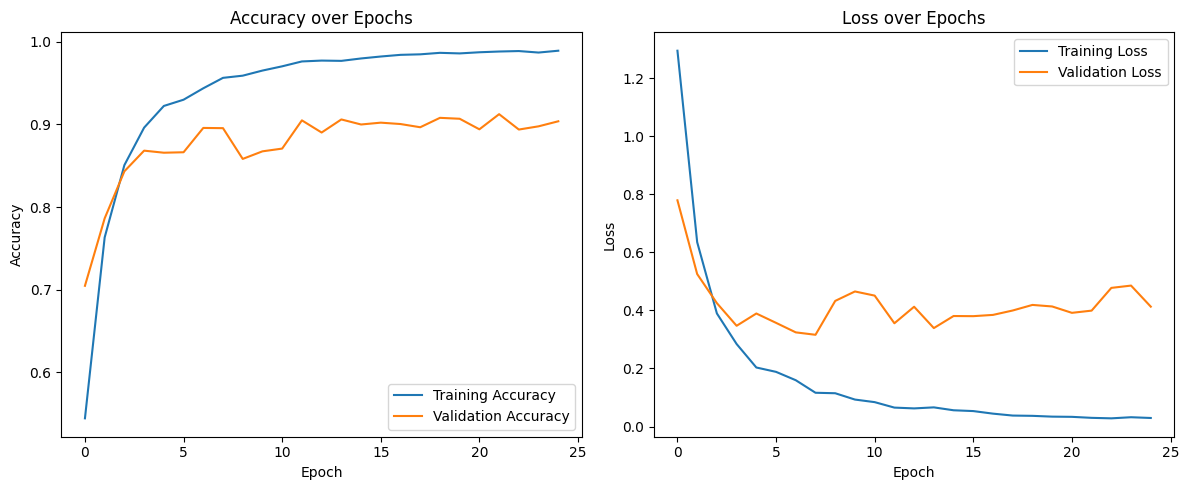

In [40]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
total_epochs = epochs

# Plot Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(total_epochs), acc, label='Training Accuracy')
plt.plot(range(total_epochs), val_acc, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(range(total_epochs), loss, label='Training Loss')
plt.plot(range(total_epochs), val_loss, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
